# Classifying Maternal Risk Levels w/ KNN, MLP, Random Forest

## Imports

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import itertools
import seaborn as sns
from itertools import product



## Data Preprocessing

### Load Data

In [58]:
maternal_health_risk = pd.read_csv("Maternal.csv")

X = maternal_health_risk.iloc[:, :-1].to_numpy()
Y = maternal_health_risk.iloc[:, -1].to_numpy()

print("Features shape:", X.shape)
print("Target shape:", Y.shape)
print(maternal_health_risk.head())


Features shape: (1014, 6)
Target shape: (1014,)
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


### Uniform Label Encoding

In [59]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y.ravel())
print(f"Classes: {label_encoder.classes_} (mapped to {np.unique(y_encoded)})")


Classes: ['high risk' 'low risk' 'mid risk'] (mapped to [0 1 2])


### Global train/val/test split (keep for all models)

In [60]:
x_temp, x_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

### Global scaling (scale on train, apply to all)

In [61]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print("Data shapes after preprocessing:")
print(f"Training: {x_train_scaled.shape}, {y_train.shape}")
print(f"Validation: {x_val_scaled.shape}, {y_val.shape}")
print(f"Test: {x_test_scaled.shape}, {y_test.shape}")


Data shapes after preprocessing:
Training: (608, 6), (608,)
Validation: (203, 6), (203,)
Test: (203, 6), (203,)


## Data Exploration

### Target Class Distributions

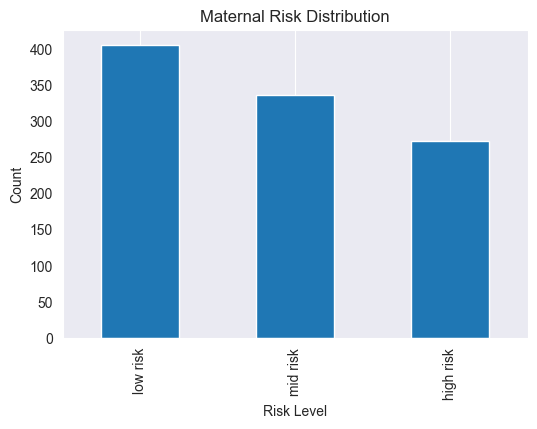

In [62]:
plt.figure(figsize=(6,4))
maternal_health_risk['RiskLevel'].value_counts().plot(kind='bar')
plt.title("Maternal Risk Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

### Feature Class Distributions

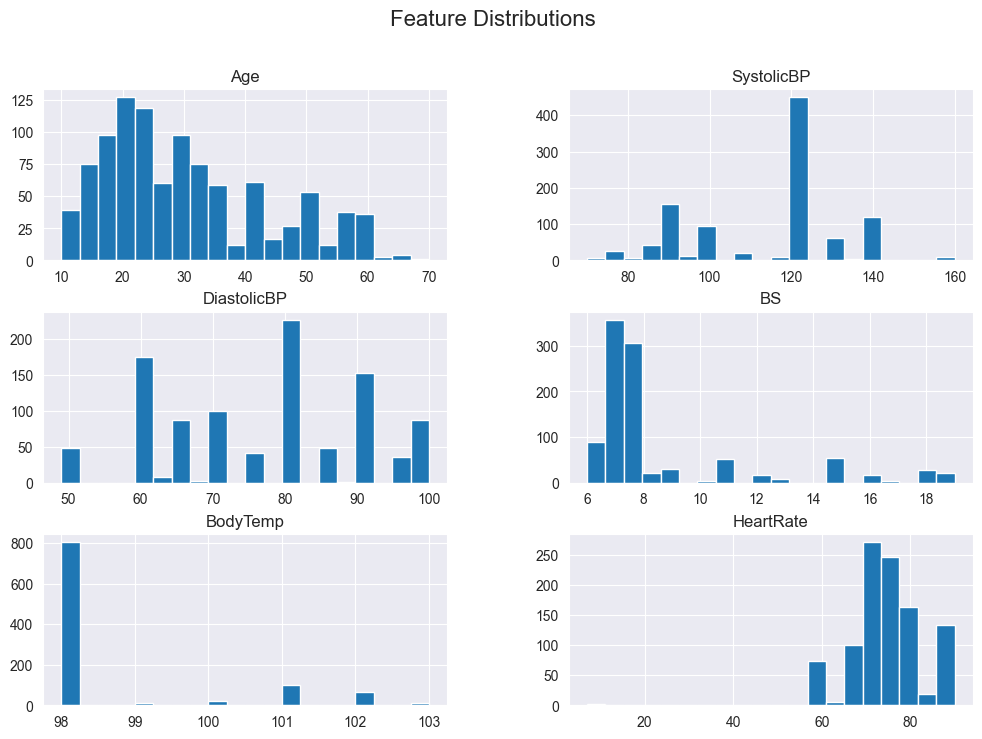

In [63]:
maternal_health_risk.iloc[:, :-1].hist(figsize=(12,8), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


### Heatmap (Correlations)

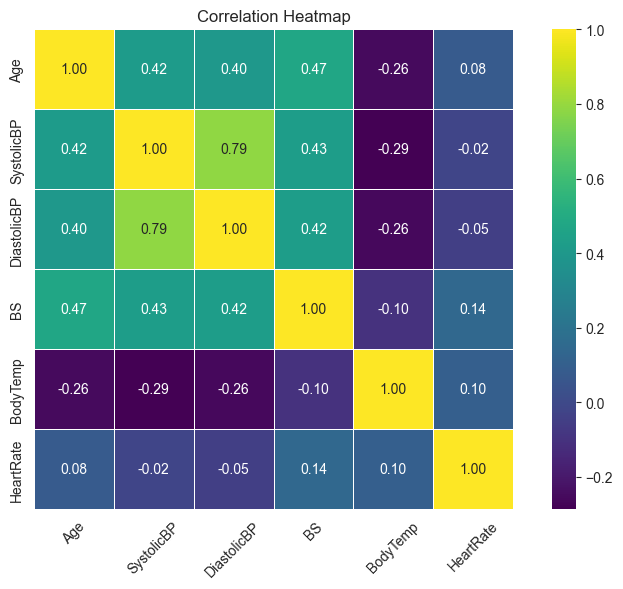

In [64]:
plt.figure(figsize=(8,6))
corr = maternal_health_risk.iloc[:, :-1].corr()

sns.heatmap(corr,
            annot=True,
            fmt='.2f',
            cmap='viridis',
            square=True,
            linewidths=0.5)

plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluation function

In [65]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"=== {model_name} Performance ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    print("="*50)

    return accuracy, precision, recall, f1


## KNN

In [66]:
y_train_raveled = y_train.ravel()

K = [1, 2, 5, 10, 50, 100, 250]

errTrain_cv_all = np.zeros(len(K))
errVal_cv_all = np.zeros(len(K))

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for i, k in enumerate(K):
    train_errors_k = []
    val_errors_k = []

    for train_index, val_index in kf.split(x_train_scaled, y_train_raveled): 
        Xtr, Xva = x_train_scaled[train_index], x_train_scaled[val_index]
        Ytr, Yva = y_train_raveled[train_index], y_train_raveled[val_index]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtr, Ytr)

        Ytr_pred = knn.predict(Xtr)
        train_errors_k.append(np.mean(Ytr_pred != Ytr))

        Yva_pred = knn.predict(Xva)
        val_errors_k.append(np.mean(Yva_pred != Yva))

    errTrain_cv_all[i] = np.mean(train_errors_k)
    errVal_cv_all[i] = np.mean(val_errors_k)

best_k_idx = np.argmin(errVal_cv_all)
best_k = K[best_k_idx]
print(f"Best K from cross-validation: {best_k} with validation error: {errVal_cv_all[best_k_idx]:.4f}")

# Train with best K
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(x_train_scaled, y_train)

# Predict validation set
y_val_pred = knn_best.predict(x_val_scaled)

# Validation Set Eval
accuracy, precision, recall, f1 = evaluate_model(
    y_val, y_val_pred,
    model_name=f"KNN (k={best_k}) on Validation Set"
)

# Test Set Eval
y_test_pred = knn_best.predict(x_test_scaled)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(
    y_test, y_test_pred,
    model_name=f"KNN (k={best_k}) on Test Set"
)

Best K from cross-validation: 1 with validation error: 0.2548
=== KNN (k=1) on Validation Set Performance ===
Accuracy:  0.7833
Precision: 0.7855
Recall:    0.7833
F1-Score:  0.7841

Confusion Matrix:
[[46  5  3]
 [ 3 64 15]
 [ 2 16 49]]

Classification Report for KNN (k=1) on Validation Set:
              precision    recall  f1-score   support

   high risk       0.90      0.85      0.88        54
    low risk       0.75      0.78      0.77        82
    mid risk       0.73      0.73      0.73        67

    accuracy                           0.78       203
   macro avg       0.80      0.79      0.79       203
weighted avg       0.79      0.78      0.78       203

=== KNN (k=1) on Test Set Performance ===
Accuracy:  0.8325
Precision: 0.8416
Recall:    0.8325
F1-Score:  0.8344

Confusion Matrix:
[[48  4  3]
 [ 1 63 17]
 [ 0  9 58]]

Classification Report for KNN (k=1) on Test Set:
              precision    recall  f1-score   support

   high risk       0.98      0.87      0.92       

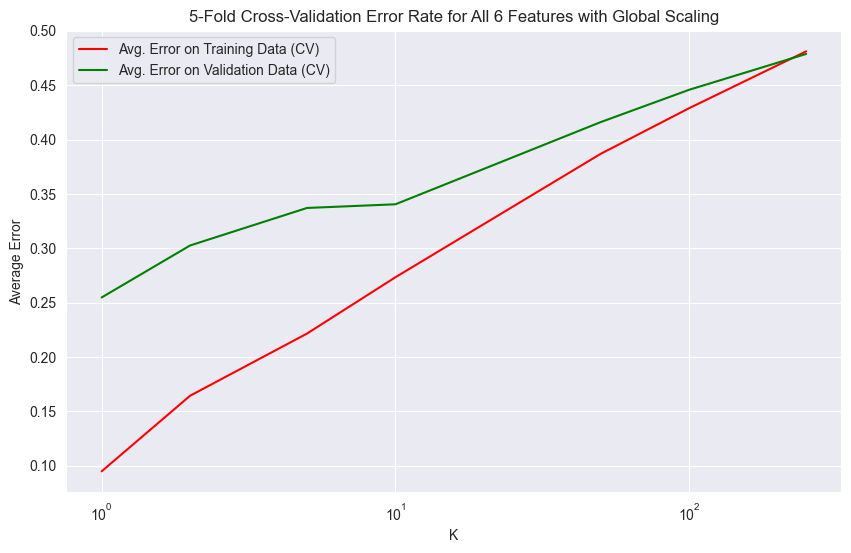

In [67]:
plt.figure(figsize=(10, 6))
plt.semilogx(K, errTrain_cv_all, color='red', label='Avg. Error on Training Data (CV)')
plt.semilogx(K, errVal_cv_all, color='green', label='Avg. Error on Validation Data (CV)')
plt.xlabel("K")
plt.ylabel("Average Error")
plt.title("5-Fold Cross-Validation Error Rate for All 6 Features with Global Scaling")  #  CHANGED: Updated title
plt.legend()
plt.grid(True)
plt.show()

## MLP

In [68]:
# Data Class
class MaternalHealthDataset(Dataset):
    def __init__(self, X, Y):
        super(MaternalHealthDataset, self).__init__()
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(Y).long()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# Model
class MLPModel(nn.Module):
    def __init__(self, input_size = 6, hidden_size = 128, num_classes = 3, dropout = 0.3):
        super(MLPModel, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.fc = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = self.mlp(x)
        x = self.fc(x)
        return x


train_data = MaternalHealthDataset(x_train_scaled, y_train)
val_data = MaternalHealthDataset(x_val_scaled, y_val)
test_data = MaternalHealthDataset(x_test_scaled, y_test)

batch_size = 32

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

# Hyperparameter Tuning
param_grid = {'hidden_sizes': [64, 128, 256],
              'learning_rates': [0.001, 0.0001, 0.00001],
              'dropout_rates': [0.2, 0.3, 0.4]}

keys = list(param_grid.keys())
values = list(param_grid.values())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

best_accuracy = 0.0
best_parameters = None

for p in param_combinations:
    model = MLPModel(
        input_size = x_train_scaled.shape[1],
        hidden_size = p['hidden_sizes'],
        num_classes = len(np.unique(y_train)),
        dropout = p['dropout_rates']
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = p['learning_rates'])

    for epoch in range(10):
        model.train()
        for x_batch, y_batch in train_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    accuracy = correct / total
    if (accuracy > best_accuracy):
        best_accuracy = accuracy
        best_parameters = p

print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_parameters)

# Train Model
model = MLPModel(
    input_size = x_train_scaled.shape[1],
    hidden_size = best_parameters['hidden_sizes'],
    num_classes = len(np.unique(y_train)),
    dropout = best_parameters['dropout_rates']
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),
                       lr = best_parameters['learning_rates'])

num_epochs = 30

loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        output = model(x_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if ((i + 1) % 100 == 0):
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, len(train_loader),
                loss.item()))
    loss_history.append(epoch_loss / len(train_loader))

# Valiation Pred's
model.eval()
y_val_pred_list = []
y_val_target_list = []

with torch.no_grad():
    for X, y in val_loader:
        output = model(X)
        _, y_pred_tag = torch.max(output, 1)
        y_val_pred_list.append(y_pred_tag.cpu().numpy())
        y_val_target_list.append(y.cpu().numpy())

y_val_pred = np.concatenate(y_val_pred_list)
y_val_target = np.concatenate(y_val_target_list)

# Validation Set Eval
print("\n" + "=" * 50)
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(
    y_val_target, y_val_pred, model_name = "MLP on Validation Set"
)

# Test Set Eval
y_pred_list = []
y_target_list = []
model.eval()

with torch.no_grad():
    for X, y in test_loader:
        output = model(X)
        _, y_pred_tag = torch.max(output, 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_target_list.append(y.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

y_target_list = [a.squeeze().tolist() for a in y_target_list]
ytest_target = list(itertools.chain.from_iterable(y_target_list))

print("\n" + "=" * 50)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(
    ytest_target, ytest_pred, model_name = "MLP on Test Set"
)


Best Accuracy: 0.7192118226600985
Best Parameters: {'hidden_sizes': 128, 'learning_rates': 0.001, 'dropout_rates': 0.3}

=== MLP on Validation Set Performance ===
Accuracy:  0.7143
Precision: 0.7119
Recall:    0.7143
F1-Score:  0.7129

Confusion Matrix:
[[43  1 10]
 [ 2 64 16]
 [ 9 20 38]]

Classification Report for MLP on Validation Set:
              precision    recall  f1-score   support

   high risk       0.80      0.80      0.80        54
    low risk       0.75      0.78      0.77        82
    mid risk       0.59      0.57      0.58        67

    accuracy                           0.71       203
   macro avg       0.71      0.71      0.71       203
weighted avg       0.71      0.71      0.71       203


=== MLP on Test Set Performance ===
Accuracy:  0.6749
Precision: 0.6765
Recall:    0.6749
F1-Score:  0.6711

Confusion Matrix:
[[48  3  4]
 [ 0 60 21]
 [ 3 35 29]]

Classification Report for MLP on Test Set:
              precision    recall  f1-score   support

   high risk  

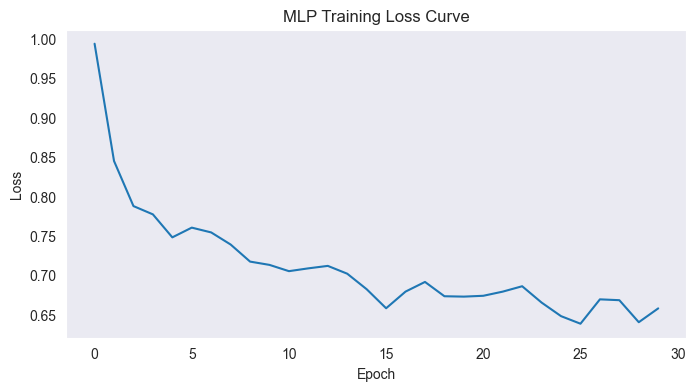

In [69]:
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("MLP Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


## Random Forest

In [70]:
# Hyperparameter grid
n_estimators_list = [50, 100, 200, 300]
max_depth_list = [None, 5, 10, 20]
min_samples_split_list = [2, 5, 10]

best_val_accuracy = 0
best_params = None
best_rf_model = None


for n_est in n_estimators_list:
    for depth in max_depth_list:
        for min_split in min_samples_split_list:

            rf = RandomForestClassifier(
                n_estimators = n_est,
                max_depth = depth,
                min_samples_split = min_split,
                random_state = 42
            )

            rf.fit(x_train_scaled, y_train)
            y_val_pred = rf.predict(x_val_scaled)
            val_acc = accuracy_score(y_val, y_val_pred)

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_params = (n_est, depth, min_split)
                best_rf_model = rf

print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Best Parameters (n_estimators, max_depth, min_samples_split): {best_params}\n")

# Validation Set Eval
print("=" * 50)
val_pred = best_rf_model.predict(x_val_scaled)
evaluate_model(y_val, val_pred, model_name = "Random Forest (Validation Set)")

# Test Set Eval
print("=" * 50)
test_pred = best_rf_model.predict(x_test_scaled)
evaluate_model(y_test, test_pred, model_name = "Random Forest (Test Set)")


Best Validation Accuracy: 0.8177
Best Parameters (n_estimators, max_depth, min_samples_split): (50, None, 5)

=== Random Forest (Validation Set) Performance ===
Accuracy:  0.8177
Precision: 0.8170
Recall:    0.8177
F1-Score:  0.8150

Confusion Matrix:
[[50  1  3]
 [ 3 70  9]
 [ 9 12 46]]

Classification Report for Random Forest (Validation Set):
              precision    recall  f1-score   support

   high risk       0.81      0.93      0.86        54
    low risk       0.84      0.85      0.85        82
    mid risk       0.79      0.69      0.74        67

    accuracy                           0.82       203
   macro avg       0.81      0.82      0.82       203
weighted avg       0.82      0.82      0.81       203

=== Random Forest (Test Set) Performance ===
Accuracy:  0.8276
Precision: 0.8283
Recall:    0.8276
F1-Score:  0.8278

Confusion Matrix:
[[51  2  2]
 [ 1 65 15]
 [ 3 12 52]]

Classification Report for Random Forest (Test Set):
              precision    recall  f1-score  

(0.8275862068965517,
 0.8282676021844412,
 0.8275862068965517,
 0.8278216458997393)

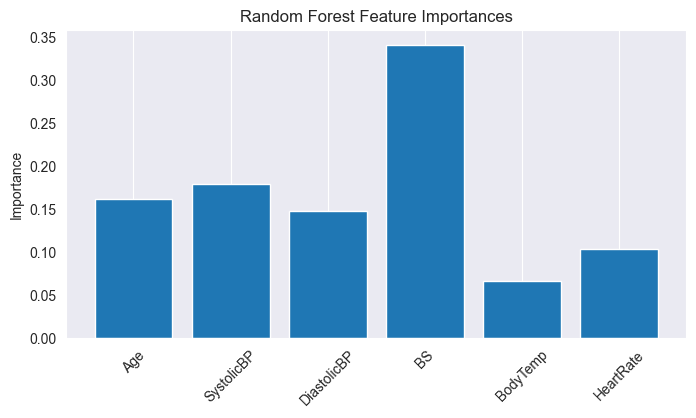

Age: 0.1621
SystolicBP: 0.1788
DiastolicBP: 0.1479
BS: 0.3417
BodyTemp: 0.0664
HeartRate: 0.1031


In [71]:
importances = best_rf_model.feature_importances_
features = maternal_health_risk.columns[:-1]

plt.figure(figsize=(8,4))
plt.bar(features, importances)
plt.title("Random Forest Feature Importances")
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.grid(axis='y')
plt.show()
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

## Model Comparisons

Difference between Test and Validation Accuracies:
KNN (k=1): 0.0492
MLP: -0.0344
Random Forest: 0.0099


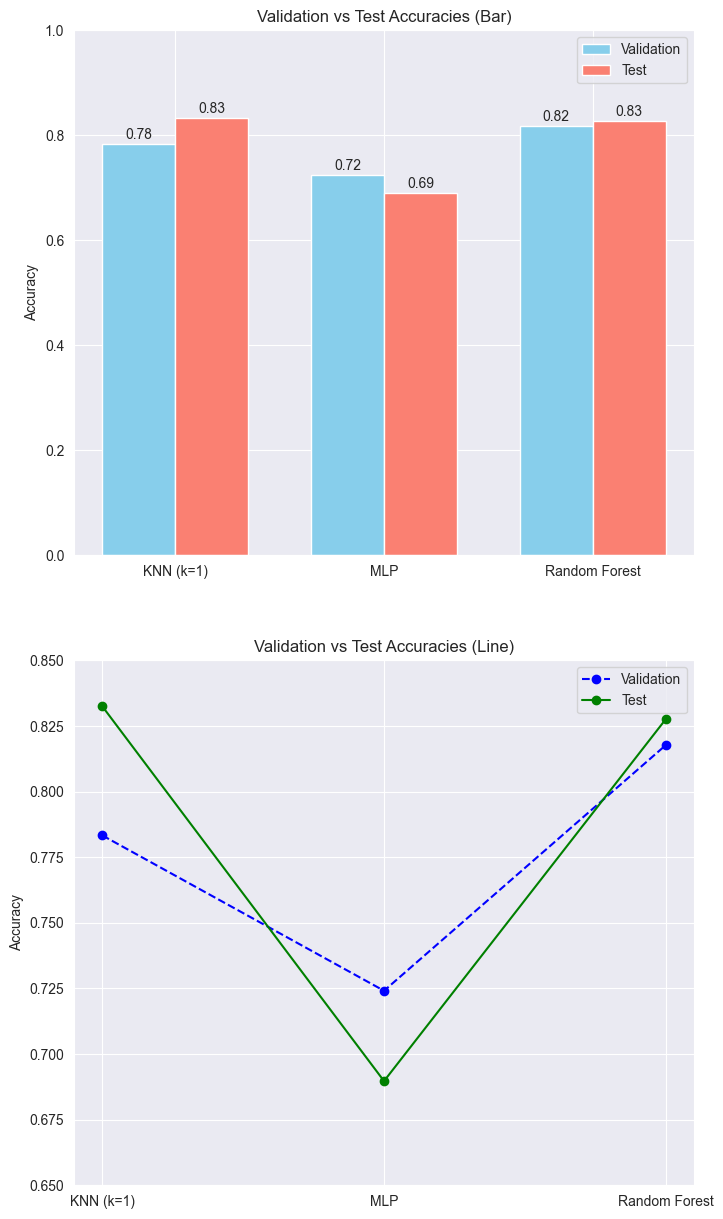

In [73]:
models = ['KNN (k=1)', 'MLP', 'Random Forest']

val_accuracies = [0.7833, 0.7241, 0.8177]
test_accuracies = [0.8325, 0.6897, 0.8276]

differences = [t - v for t, v in zip(test_accuracies, val_accuracies)] # Calculate differences
print("Difference between Test and Validation Accuracies:")
for model, diff in zip(models, differences):
    print(f"{model}: {diff:.4f}")

fig, axs = plt.subplots(2, 1, figsize=(8, 15))

# Bar Chart
width = 0.35
x = range(len(models))
axs[0].bar([p - width/2 for p in x], val_accuracies, width, label='Validation', color='skyblue')
axs[0].bar([p + width/2 for p in x], test_accuracies, width, label='Test', color='salmon')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Validation vs Test Accuracies (Bar)')
axs[0].legend()
for i in range(len(models)):
    axs[0].text(i - width/2, val_accuracies[i]+0.01, f"{val_accuracies[i]:.2f}", ha='center')
    axs[0].text(i + width/2, test_accuracies[i]+0.01, f"{test_accuracies[i]:.2f}", ha='center')

# Line Chart
axs[1].plot(models, val_accuracies, marker='o', linestyle='--', color='blue', label='Validation')
axs[1].plot(models, test_accuracies, marker='o', linestyle='-', color='green', label='Test')
axs[1].set_ylim(0.65, 0.85)
axs[1].set_title('Validation vs Test Accuracies (Line)')
axs[1].set_ylabel('Accuracy')
axs[1].grid(True)
axs[1].legend()

